In [1]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhishekrana2511","key":"f8a1d1d85a375f1a9a31a265179ea23c"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

lung-and-colon-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('lung-and-colon-cancer-histopathological-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import gc
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Step 2: Data Visualization
path = '/content/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_scc', 'lung_n', 'lung_aca']

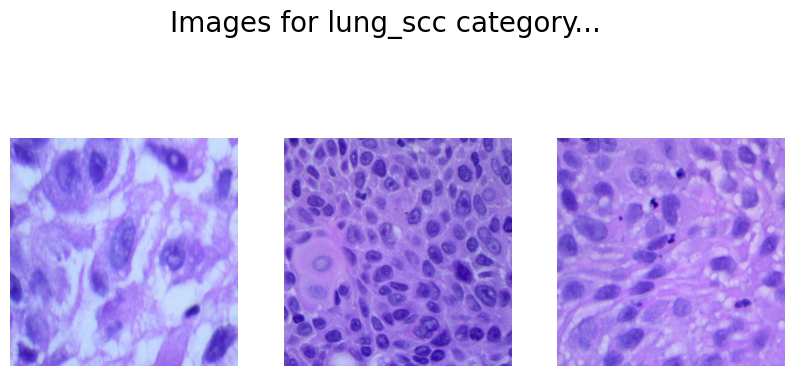

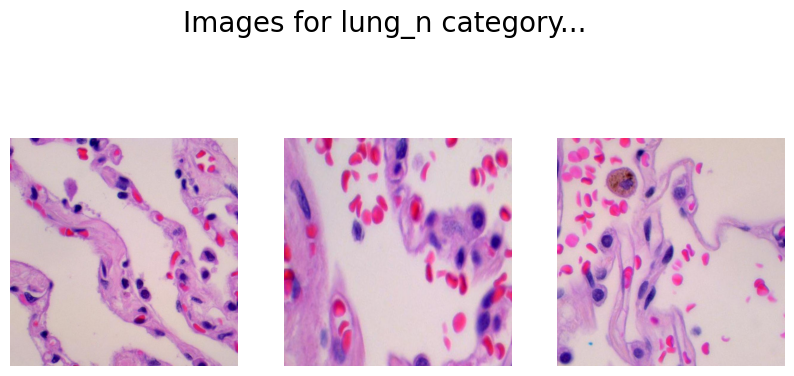

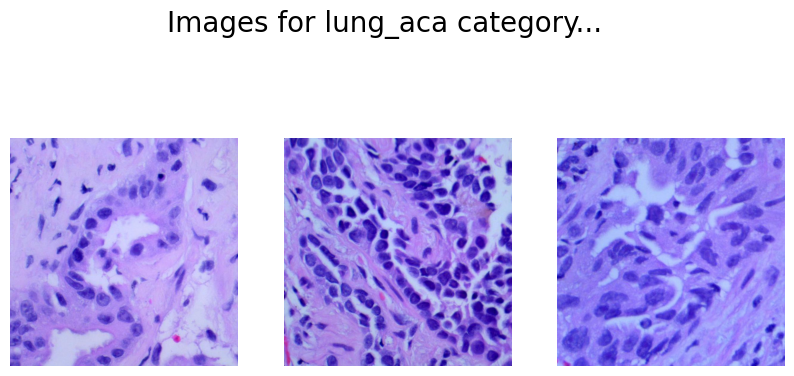

In [8]:
# Display random images from each class
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    # Display 3 random images for each class
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    fig.suptitle(f'Images for {cat} category...', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [9]:
# img = Image.open('/content/drive/MyDrive/New Folder/lung_image_sets/lung_aca/lungaca1.jpeg')
# img = np.array(img)
# # img

In [10]:
# Step 3: Data Preparation for Training
IMG_SIZE = 186
SPLIT = 0.2
EPOCHS = 15
BATCH_SIZE = 16

In [11]:
# Lists to store images and labels
X = []
Y = []

# Loop through each class
# for i, cat in enumerate(classes):
#     images = glob(f'{path}/{cat}/*.jpeg')
#     # print(images)
#     # Read and resize each image, append to lists
#     for image in images:
#         img = cv2.imread(image)
#         X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
#         Y.append(i)

# np.save('X.npy', X)
# np.save('Y.npy', Y)


X = np.load('X.npy')
Y = np.load('Y.npy')

In [12]:
# print(type(X))
# print(Y)

In [13]:
# Convert lists to NumPy arrays
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values
one_hot_encoded_Y[300]

array([1, 0, 0], dtype=uint8)

In [14]:
# Split the dataset into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size=SPLIT,
                                                  random_state=2022)

In [15]:
# Step 4: Model Development
# Define the CNN model using Keras Sequential API
model = keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    # layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    # layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])


In [16]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 186, 186, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 93, 93, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 93, 93, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 128)       0

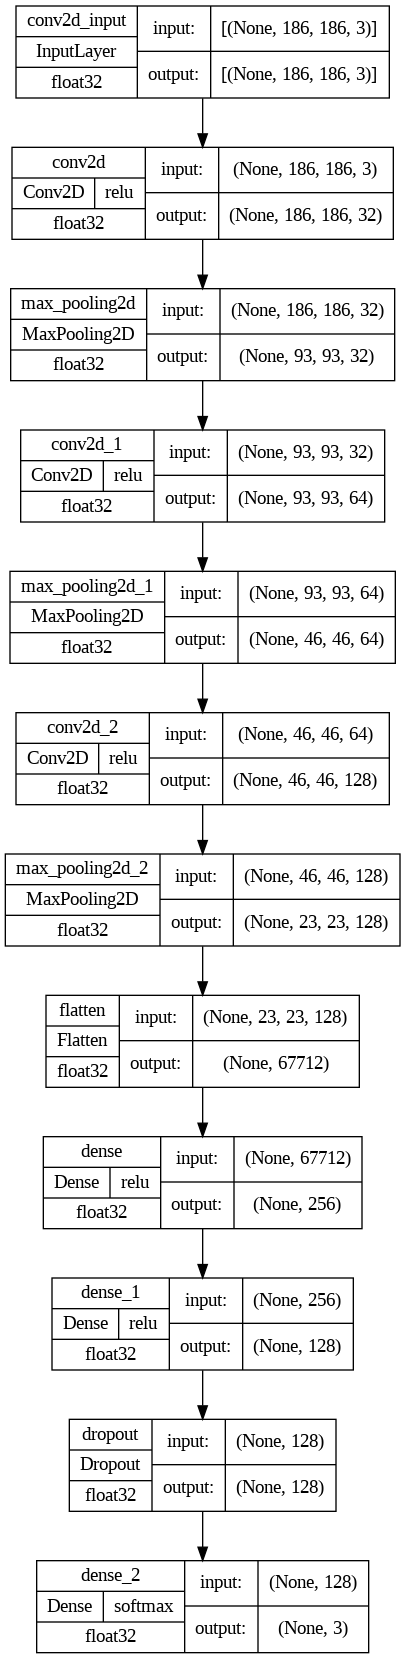

In [17]:
# Visualize the model architecture
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

In [18]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [19]:
# Step 5: Callbacks
# Define custom callback to stop training when validation accuracy reaches 90%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\nValidation accuracy has reached 90%, stopping further training.')
            self.model.stop_training = True

In [20]:
# Define EarlyStopping and ReduceLROnPlateau callbacks
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [21]:
# Step 6: Model Training
# Train the model with the training dataset and validate on the validation dataset
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[myCallback()]
                    )
model.save('lung_cancer_detection_model.h5')


model = keras.models.load_model('lung_cancer_detection_model.h5')

Epoch 1/15
  6/750 [..............................] - ETA: 18s - loss: 383.9713 - accuracy: 0.3333

750/750 [==============================] - 34s 26ms/step - loss: 3.7183 - accuracy: 0.7427 - val_loss: 0.4171 - val_accuracy: 0.8103
Epoch 2/15
750/750 [==============================] - 18s 25ms/step - loss: 0.4621 - accuracy: 0.7985 - val_loss: 0.4472 - val_accuracy: 0.8107
Epoch 3/15
750/750 [==============================] - 19s 25ms/step - loss: 0.4513 - accuracy: 0.8025 - val_loss: 0.3937 - val_accuracy: 0.8303
Epoch 4/15
750/750 [==============================] - 18s 24ms/step - loss: 0.4288 - accuracy: 0.8181 - val_loss: 0.3542 - val_accuracy: 0.8447
Epoch 5/15
750/750 [==============================] - 19s 25ms/step - loss: 0.3751 - accuracy: 0.8412 - val_loss: 0.3547 - val_accuracy: 0.8613
Epoch 6/15
750/750 [==============================] - 20s 27ms/step - loss: 0.4116 - accuracy: 0.8269 - val_loss: 0.3255 - val_accuracy: 0.8580
Epoch 7/15
750/750 [==============================] - 18s 25ms/step - loss: 0.5189 - accuracy: 0.7714 - val_loss: 0.4444 - val_accuracy: 0.7993
Epo

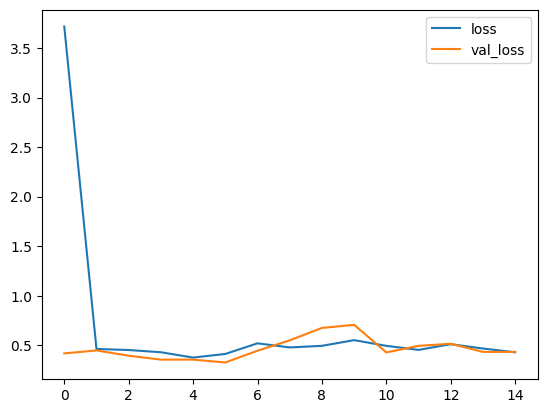

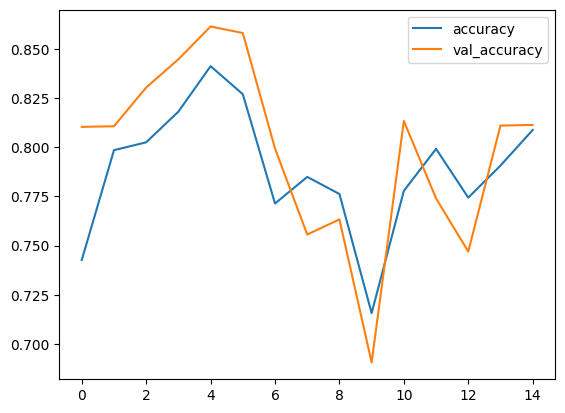

In [22]:
# Step 7: Visualize Training Metrics
# Plot training and validation loss over epochs
# Plot training and validation accuracy over epochs
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [23]:
# Step 8: Model Evaluation
# Predict class labels for the validation dataset
Y_pred = model.predict(X_val)
# print(Y_pred, Y_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
# print(Y_pred, Y_val)


94/94 [==============================] - 1s 11ms/step


In [24]:
# Confusion matrix and classification report for model evaluation
print(metrics.confusion_matrix(Y_val, Y_pred))
print(metrics.classification_report(Y_val, Y_pred, target_names=classes))

[[867   0 120]
 [  0 920  57]
 [385   4 647]]
              precision    recall  f1-score   support

    lung_scc       0.69      0.88      0.77       987
      lung_n       1.00      0.94      0.97       977
    lung_aca       0.79      0.62      0.70      1036

    accuracy                           0.81      3000
   macro avg       0.82      0.81      0.81      3000
weighted avg       0.82      0.81      0.81      3000

